In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import numpy as np

In [13]:
class CDCDataAgent:
    def __init__(self, data_path):
        # Initialize the AI Agent with data
        def load_data(url):
            response = urlopen(url)
            # from url in data
            data_json = json.loads(response.read())
            data = data_json["data"]
            column_names = []
            for one_col_meta in data_json["meta"]['view']["columns"]:
              if one_col_meta["fieldName"].startswith(":"):
                column_names.append(one_col_meta["fieldName"][1:])
              else:
                column_names.append(one_col_meta["fieldName"])
            df= pd.DataFrame(data , columns= column_names)
            return df
        self.data = load_data(data_path)  # Load your historical CDC data from a CSV file
        self.conversation_history = []  # Store conversation history
    def analyze_behavioral_trends(self):
        # Analyze trends in behavioral indicators among unvaccinated people
        # Focus on columns like 'indicator_name', 'time_year', 'estimate', 'coninf_95', etc.

        # Filter data for unvaccinated individuals and focus columns
        valid_group_categories = [
            'Vaccinated (>=1 dose)',
            'Definitely will get vaccinated',
            'Probably or definitely will not get vaccinated',
            'Probably will get vaccinated or are unsure'
        ]

        unvaccinated_data = self.data[(self.data['group_category'].isin(valid_group_categories))]
        focus_columns = ['indicator_name', 'time_year', 'estimate', 'coninf_95']
        unvaccinated_data = unvaccinated_data[focus_columns]
        # Group the data by 'indicator_name' and 'time_year'
        grouped_data = unvaccinated_data.groupby(['indicator_name', 'time_year'])

        # Calculate mean, standard deviation, and trends for each behavioral indicator
        for (indicator_name, time_year), group in grouped_data:
            mean_estimate = group['estimate'].mean()
            std_estimate = group['estimate'].std()

            # Detect trends based on historical estimates (e.g., increasing, decreasing)
            trend = 'stable'
            if group['estimate'].diff().mean() > 0:
                trend = 'increasing'
            elif group['estimate'].diff().mean() < 0:
                trend = 'decreasing'

            # Print or store analysis results
            print(f"Behavioral Indicator: {indicator_name}")
            print(f"Time Year: {time_year}")
            print(f"Mean Estimate: {mean_estimate}")
            print(f"Standard Deviation Estimate: {std_estimate}")
            print(f"Trend: {trend}")
            print("\n")

    def offer_vaccination_guidance(self):
        # Offer guidance on improving vaccination rates for future infections
        # Filter data for 'Vaccination Rate' indicator and focus columns
        scopes = {1:'National',2:'Jurisdictional'}
        print(scopes)
        scope=int(input("Please Enter the Scope (1 or 2)"))
        if scope not in [1,2]:
          return "Your entered value is not in scope"
        vaccination_data = self.data[(self.data['indicator_name'] == 'Vaccination Rate')]
        # Filter by scope (National or Jurisdictional)
        if scopes[scope] == 'National':
            vaccination_data = vaccination_data[(vaccination_data['geography_type'] == 'National Estimates')]
        elif scopes[scope] == 'Jurisdictional':
            vaccination_data = vaccination_data[(vaccination_data['geography_type'] == 'Jurisdictional Estimates')]

        focus_columns = ['time_year', 'estimate']
        vaccination_data = vaccination_data[focus_columns]

        # Group data by 'time_year'
        grouped_data = vaccination_data.groupby('time_year')

        # Calculate average vaccination rate over time
        avg_vaccination_rate = grouped_data['estimate'].mean()

        # Analyze trends in vaccination rate
        trend = 'stable'
        if avg_vaccination_rate.diff().mean() > 0:
            trend = 'increasing'
        elif avg_vaccination_rate.diff().mean() < 0:
            trend = 'decreasing'

        # Provide guidance based on trends
        guidance = []

        # Analysis 1: Trend-based Guidance
        if trend == 'increasing':
            guidance.append("Efforts to increase vaccination rates are paying off. Maintain the momentum.")
        elif trend == 'decreasing':
            guidance.append("Vaccination rates are declining. Consider targeted campaigns to boost vaccination.")
        else:
            guidance.append("Continue current vaccination efforts.")

        # Analysis 2: Yearly Comparison
        if len(avg_vaccination_rate) > 1:
            last_year_rate = avg_vaccination_rate.iloc[-2]
            current_year_rate = avg_vaccination_rate.iloc[-1]
            if current_year_rate > last_year_rate:
                guidance.append("The vaccination rate for the current year is higher than the previous year.")
            elif current_year_rate < last_year_rate:
                guidance.append("The vaccination rate for the current year is lower than the previous year. Investigate reasons.")
            else:
                guidance.append("The vaccination rate for the current year is similar to the previous year.")

        # Print or return guidance
        print(f"Vaccination Rate Analysis ({scope} scope):")
        print(f"Average Vaccination Rate Trend: {trend}")
        for g in guidance:
            print(f"Guidance: {g}")

    def visualize_data(self):
        # Visualize data trends using plots
        # Example: create line plots and bar plots to visualize trends and comparisons
        indicators_of_not_or_little_interest = ['Not At All or A Little Difficult to Get Vaccinated',
                                    'Moderately or Very Concerned About COVID-19',
                                    'Healthcare Provider Recommended I get a COVID-19 vaccine',
                                    'Work or School Requires COVID-19 Vaccination']
        indicator_of_interest = 'Very or Completely Confident in COVID-19 Vaccine Safety'
        selected_demographic = 'Vaccination uptake and intention'
        # Filter data for specific indicator and demographic and focus columns
        selected_data = self.data[(self.data['indicator_category'] == indicator_of_interest) &
                                  (self.data['group_name'] == selected_demographic)]
        focus_columns = ['time_year', 'estimate', 'sample_size']
        selected_data = selected_data[focus_columns]

        # Group data by 'time_year'
        grouped_data = selected_data.groupby('time_year')

        # Calculate average estimate and sample size over time
        avg_estimate = grouped_data['estimate'].mean()
        avg_sample_size = grouped_data['sample_size'].mean()

        # Create line plot to visualize trends in estimate
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.lineplot(x=avg_estimate.index, y=avg_estimate.values)
        plt.title('Trend of Indicator of Interest Over Time')
        plt.xlabel('Year')
        plt.ylabel('Average Estimate')
        plt.xticks(rotation=45)

        # Create bar plot to compare sample sizes
        plt.subplot(1, 2, 2)
        sns.barplot(x=avg_sample_size.index, y=avg_sample_size.values)
        plt.title('Average Sample Size Over Time')
        plt.xlabel('Year')
        plt.ylabel('Average Sample Size')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def data_validation_and_transformation(self):
        try:
            # Handling Date/Time Data
            self.data['created_at'] = pd.to_datetime(self.data['created_at'], errors='coerce')
            self.data['updated_at'] = pd.to_datetime(self.data['updated_at'], errors='coerce')
            # Data Quality Checks (e.g., removing duplicates)
            self.data.drop_duplicates(inplace=True)

            # Handling Missing Values
            self.data.dropna(subset=['estimate', 'coninf_95', 'sample_size'], inplace=True)

            # Convert columns to numeric if possible
            numeric_columns = ['estimate', 'coninf_95', 'sample_size']
            for col in numeric_columns:
              self.data[col].replace('', np.nan, inplace=True)
              if not pd.api.types.is_numeric_dtype(self.data[col]):
                  # Try to convert non-numeric values to numeric (NaN for non-convertible)
                  self.data[col] = pd.to_numeric(self.data[col], errors='coerce')


            self.data = self.data[self.data['estimate'] >= 0]

            print("Data validation and transformation completed successfully.")
        except Exception as e:
            print(f"Error during data validation and transformation: {str(e)}")

    def save_data(self, file_path):
        # Save processed data to a CSV file for persistent storage
        self.data.to_csv(file_path, index=False)
        print(f"Data saved to {file_path}.")

    def load_data(self, file_path):
        # Load data from a CSV file
        self.data = pd.read_csv(file_path)
        print(f"Data loaded from {file_path}.")

    def remember_conversations(self, conversation):
        # Store conversation history for contextual understanding
        self.conversation_history.append(conversation)



Data validation and transformation completed successfully.
Behavioral Indicator: Concern About COVID-19 Disease
Time Year: 2021
Mean Estimate: 34.3536600496278
Standard Deviation Estimate: 17.555984907908776
Trend: increasing


Behavioral Indicator: Concern About COVID-19 Disease
Time Year: 2022
Mean Estimate: 28.261099020674646
Standard Deviation Estimate: 18.10748782070299
Trend: decreasing


Behavioral Indicator: Concern About COVID-19 Disease
Time Year: 2023
Mean Estimate: 22.016421291053227
Standard Deviation Estimate: 14.645387775565691
Trend: decreasing


Behavioral Indicator: Confidence In COVID-19 Vaccine Safety
Time Year: 2021
Mean Estimate: 39.47993333333333
Standard Deviation Estimate: 32.6248948888201
Trend: decreasing


Behavioral Indicator: Confidence In COVID-19 Vaccine Safety
Time Year: 2022
Mean Estimate: 39.92574316290131
Standard Deviation Estimate: 32.49567834096418
Trend: decreasing


Behavioral Indicator: Confidence In COVID-19 Vaccine Safety
Time Year: 2023
Mean

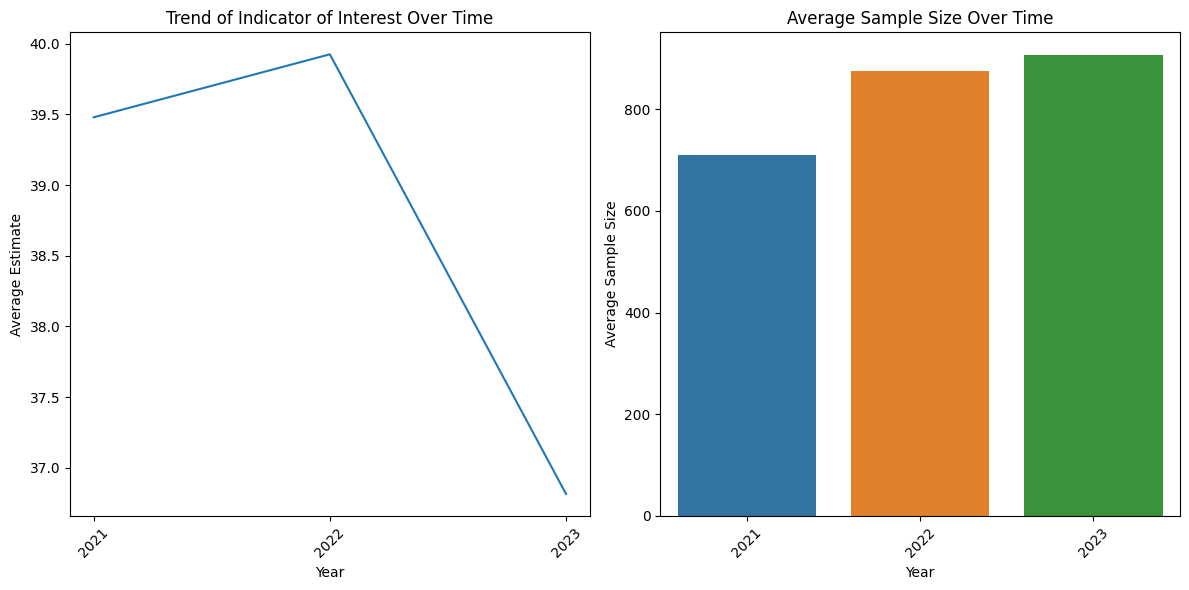

Data saved to processed_cdc_data.csv.
Data loaded from processed_cdc_data.csv.


In [14]:
# Example Usage:
if __name__ == "__main__":
    # Initialize the CDCDataAgent with the data file path
    data_path = 'https://data.cdc.gov/api/views/qz99-wyhv/rows.json?accessType=DOWNLOAD'
    cdc_agent = CDCDataAgent(data_path)

    # Data validation and transformation
    cdc_agent.data_validation_and_transformation()

    # Analyze behavioral trends among unvaccinated people
    cdc_agent.analyze_behavioral_trends()

    # Offer vaccination guidance based on historical data (national scope)
    cdc_agent.offer_vaccination_guidance()

    # Offer vaccination guidance based on historical data (jurisdictional scope)
    cdc_agent.offer_vaccination_guidance()

    # Visualize data trends
    cdc_agent.visualize_data()



    # Save processed data to a file
    cdc_agent.save_data('processed_cdc_data.csv')

    # Load data from a file
    cdc_agent.load_data('processed_cdc_data.csv')

    # Remember conversations for historical context
    cdc_agent.remember_conversations("User: What are the trends in my region?")
    cdc_agent.remember_conversations("User: Tell me more about vaccination rates.")